# 3.1 Снова возвращаемся к деревьям 

В этом уроке поговорим, почему наши деревья из второго модуля все еще переобучены! Да сколько можно?

Мы подходим к завершению краткого введения в `data science`, машинное обучение. 

В этой неделе ещё немного поговорим про решающие деревья; про более продвинутые методы, которые получаются на их основе; затронем скорее в обзорном ключе направления, в которых можно двигаться дальше, если вам интересна эта тема и вы хотите развиваться в машинном обучении; поговорим про всякие интересные штуки; пообщаемся с приглашённым экспертом в нейросетях.

Будет интересно и давайте продолжать.

Итак, второй модуль мы завершили на той ноте, что разобрались какую задачу решает модель машинного обучения, если мы решаем задачу классификации. Т.е. задача классификации понятна - классифицировать объект. Но вот как именно подойти к этому решению?

Нам очевидно нужно натренировать наше дерево решений так, чтобы оно смогло на обучающих данных вычленить некоторую закономерность, которую можно было бы обобщить на те наблюдения, которые раньше оно не видело. И в данном случае нам поможет концепция тестового и обучающего множества, валидационного множества, кросс-валидации, подбора оптимального параметра и т.д.

Я думаю, вы уже сразу заметили, что дерево решений в этом смысле как бы и хочет сделать как лучше, а получается, как всегда. 

Дерево решений - ужасно переобучаемый алгоритм. Всё, что в него заложено - вгрызаться в наши данные как можно глубже и на практике это приводит к тому, что, если дерево решений не контролировать, то единственное, что мы получим - переобученное дерево решений, которое очень сильно вычислит закономерности, зависящие от контекста обучающей выборки, а не общую закономерность, которую можно обобщить и на новые данные.

Решением такой проблемы является подбор параметров нашего дерева, и мы разобрали один параметр - глубина, потому что он по сути самый серьезный для дерева решений. При прочих равных чем глубже дерево, тем оно более переобучено. НО! Бывают ситуации, когда глубокое дерево не является переобученным, т.е. просто в данной задаче нельзя обойтись деревом меньшей глубины.

**Запомните: если при прочих равных мы можем добиться сходих метрик качества при меньшей глубине дерева, то лучше обойтись меньшей глубиной.**

Однако даже после тюнинга глубины дерева можно заподозрить, что дерево всё ещё переобучено. на самом деле в каком-то смысле дерево решений всегда будет переобучено - такова природа этого алгоритма. 

Что можно заметить?

У нас как минимум есть всего два наблюдения в одном из финальных прямоугольников. 

![](images/tree.png)

И очевидно, что этот вот if, который разделит исходную более высокую выборку из 107 наблюдений на две части, в одной из которых окажется всего 2 элемента - кажется это довольно частая закономерность. И было бы здорово от этого избавиться. Возможно даже лучше нашему дереву решений будет, если мы заложим некоторое ограничение на то, какой размер выборки мы будем считать допустимым для того, чтобы ещё раз посплититься внутри этой выборки. И первое, что приходит на ум это ограничение глубины дерева. Например, задать глубину дерева 2. Но мы при этом потеряли бы важный третий слой глубины.

Но у дерева есть не только глубина, но и другие важные параметры дерева решений. Например, `min_sample_split` - параметр показывающий допустимый размер выборки для дальнейшего сплита.


In [1]:
%matplotlib inline
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from graphviz import Source
from IPython.display import SVG
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}.container{width:70% !important;}</style></style>"
HTML(style)
# display(HTML("<style>.container { width:100% !important; }</style>"))
# %config IPCompleter.greedy=True
# sudo apt-get install graphviz

In [2]:
titanic_data = pd.read_csv('.././resources/train.csv')

In [3]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
x = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

In [5]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [6]:
y = titanic_data['Survived']
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [7]:
x = pd.get_dummies(x)
x.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [8]:
x = x.fillna({'Age': x['Age'].median()})

In [9]:
x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size=0.33, random_state=42)

In [10]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

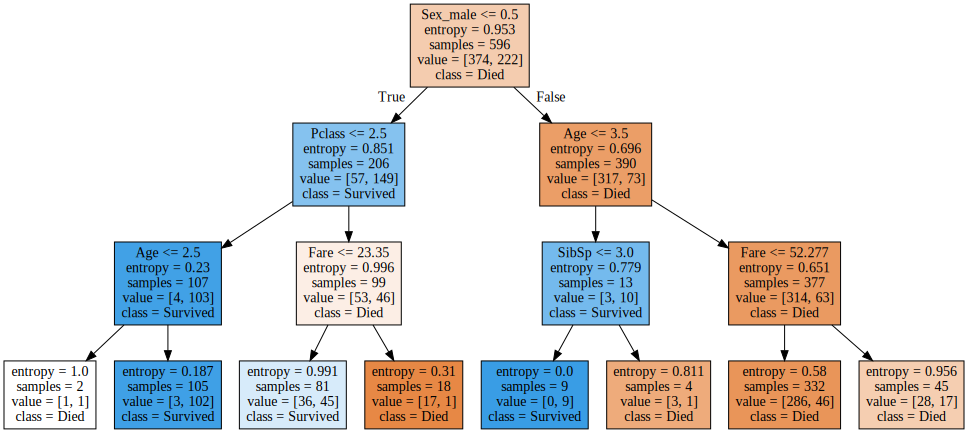

In [11]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(x),
                                   class_names=['Died','Survived'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

In [12]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100)
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

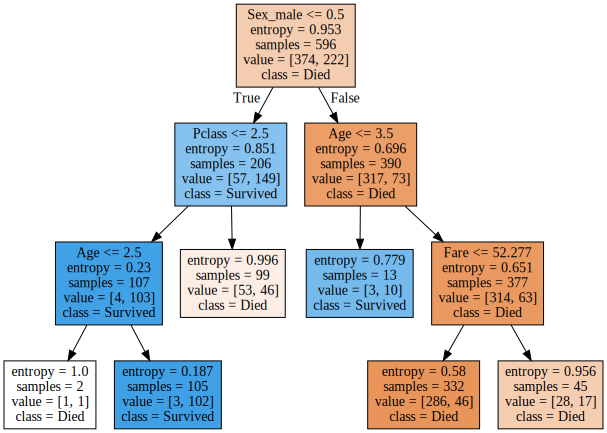

In [13]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(x),
                                   class_names=['Died','Survived'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

In [14]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10)
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

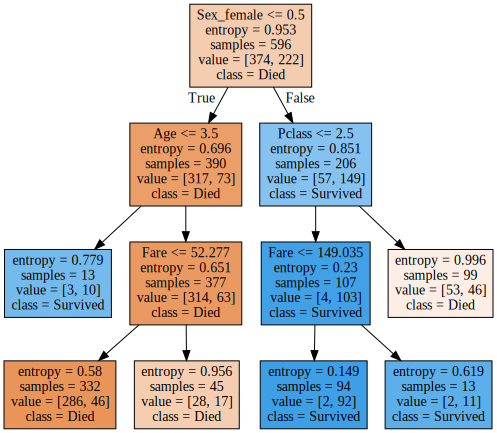

In [15]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(x),
                                   class_names=['Died','Survived'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

In [16]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10, 
                                  min_impurity_decrease=0.01)
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.01, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

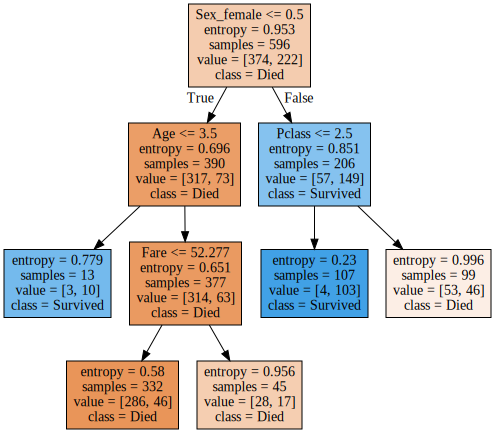

In [17]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(x),
                                   class_names=['Died','Survived'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

Сырой словарь -  Значения, необходимые для разделения узла:

1) min_impurity_decrease - ожидаемое минимальное уменьшение неопределенности (IG)

2) min_samples_split- минимальное количество сэмплов на входе узла

3) min_samples_leaf - минимальное количество сэмплов в выходном(ых) листе(ах)